In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/ETH.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test 5:3:2
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 98ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 2/100
16/16 [==============================] - 1s 66ms/step - loss: 7.2858e-04 - val_loss: 0.0034
Epoch 3/100
16/16 [==============================] - 1s 65ms/step - loss: 2.9024e-04 - val_loss: 0.0013
Epoch 4/100
16/16 [==============================] - 1s 66ms/step - loss: 1.9543e-04 - val_loss: 0.0025
Epoch 5/100
16/16 [==============================] - 1s 68ms/step - loss: 1.5428e-04 - val_loss: 0.0014
Epoch 6/100
16/16 [==============================] - 1s 69ms/step - loss: 1.6481e-04 - val_loss: 0.0023
Epoch 7/100
16/16 [==============================] - 1s 67ms/step - loss: 1.6024e-04 - val_loss: 0.0013
Epoch 8/100
16/16 [==============================] - 1s 67ms/step - loss: 1.5188e-04 - val_loss: 0.0017
Epoch 9/100
16/16 [==============================] - 1s 90ms/step - loss: 1.5061e-04 - val_loss: 0.0013
Epoch 10/100
16/16 [==============================] - 2s 108ms/step 

In [ ]:
# Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 11ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

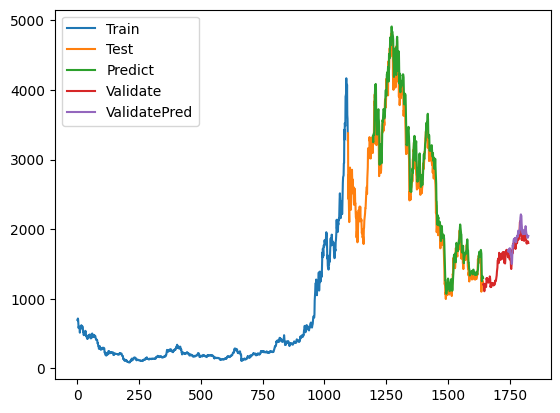

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [46]:
# Respliting train test
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]
# Repredictions on the testing set
x_test1 = np.array(test_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_test1 = np.array(test_data1['Price'])

# Repredictions on the validation set
x_val1 = np.array(val_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_val1 = np.array(val_data1['Price'])

In [47]:
# Calculate evalution
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 458.266160696125
Testing RMSE: 1523.0647331160897
Validation MAPE: 28.163667065965836
Testing MAPE: 73.58444633066587
Validation MAE: 379.869903139981
Testing MAE: 1243.7567715962252
